# NYCU 2022 Machine Learning (Homework2)

##### AUTHOR: Kuan-Wei Chen / NYCU IEE Oasis Lab / 310510221
##### CODE TYPE: Python

----------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# you can choose one of the following package for image reading/processing
import cv2
import PIL

In [2]:
from os import listdir
from os.path import isdir, join
from PIL import Image

In [3]:
n_test = 32
# n_test = 256

----

## 1 Classification

### (1) least squares for classfication
### (2) logistic regression model for classfication

### Step 1: Load Data

In [4]:
path = './MNIST'

In [5]:
all_targets = [name for name in listdir(path) if isdir (join(path, name))]
print("all tragets: ", all_targets)

all tragets:  ['9', '8', '7', '6', '5', '4', '3', '2', '1', '0']


In [6]:
num_samples = 0

for target in all_targets:
    print("class ", target, ": ",len(listdir(join(path, target))))
    num_samples += len(listdir(join(path, target)))

print("Total samples: ", num_samples)

class  9 :  128
class  8 :  128
class  7 :  128
class  6 :  128
class  5 :  128
class  4 :  128
class  3 :  128
class  2 :  128
class  1 :  128
class  0 :  128
Total samples:  1280


----

### Step2: Prepare Dataset

In [7]:
def one_hot(num, c):
    vec = np.zeros(num)
    vec[c] = 1
    
    return vec

In [8]:
dataset = []

for idx, target in enumerate(all_targets):
    for imgName in listdir(join(path, target)):
        # file path
        filePath = join(path, target, imgName)
        
        # image
        image = Image.open(filePath)
        image = np.array(image)
        
        # label
        label = int(target)
        
        dataset.append([image, one_hot(10, label), int(label)])

In [9]:
dataset = np.array(dataset, dtype=object) 

In [10]:
print("number of data in dataset: ", len(dataset))

number of data in dataset:  1280


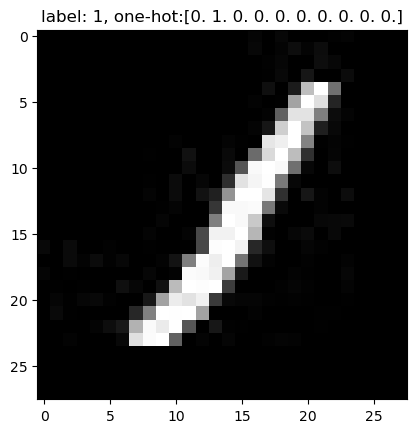

In [11]:
import random

data = random.choice(dataset)
plt.imshow(data[0], cmap='gray')
plt.title('label: {y}, one-hot:{one_hot}'.format(y=data[2], one_hot=data[1]))
plt.show()

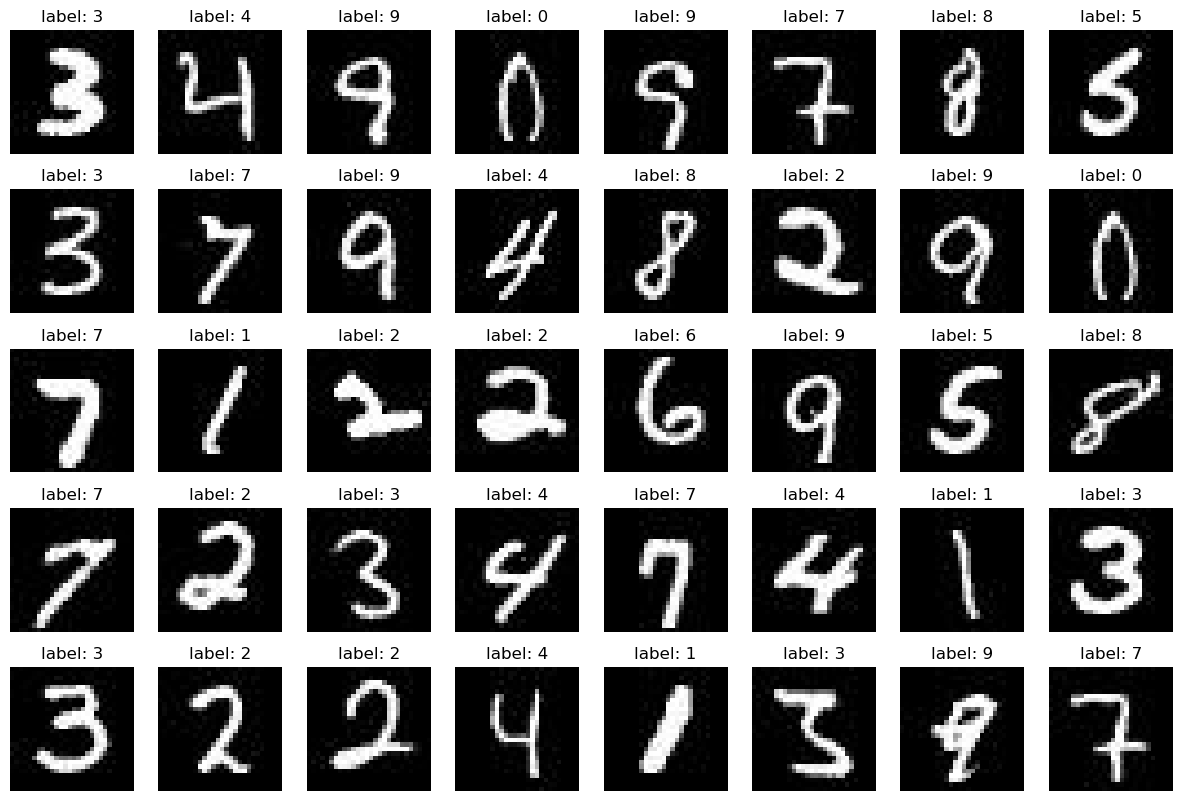

In [12]:
fig = plt.figure(figsize=(15,10))
for i in range(40):  
    ax = fig.add_subplot(5, 8, i+1)
    data = random.choice(dataset)
    ax.imshow(data[0], cmap='gray')
    
    ax.set_title('label: {y}'.format(y=data[2]))
    plt.axis('off')


----

### Step3: Prepare training & testing dataset

#### Normalization

In [13]:
def norm(src):
    dst = src / 255.
    return dst

In [14]:
dataset_norm = []

for data in dataset:
    norm_data = norm(data[0])
    dataset_norm.append([norm_data, data[1], data[2]])


In [15]:
dataset_norm[0]

[array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.02352941, 0.        ,
         0.        , 0.00392157, 0.02745098, 0.00392157, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.00392157,
         0.        , 0.        , 0.        , 0.02745098, 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.02352941, 0.02352941,
         0.01176471, 0.        , 0.        , 0.        , 0.00784314,
         0.03529412, 0.00784314, 0.        , 0.        , 0.01176471,
         0.01176471, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.02352941, 0.01960784, 0.00784314, 0.00784314, 0.00392157,
         0.

#### Train & Test split (pick training data)

In [16]:
def train_test_split(dataset, test_num):
    offset = 0
    train_dataset = []
    test_dataset = []
    total_idx_list = []
    random_ids_list = []
    res_idx_list = []
    
    for i in range(len(dataset)):
        total_idx_list.append(i)
    
    for _ in range(10):        
        random_ids = np.random.choice(range(0+offset, 128+offset), test_num, replace=False)
        random_ids_list += random_ids.tolist()
        offset += 128
    
    res_idx_list = list(set(total_idx_list) ^ set(random_ids_list))
    
    for idx in random_ids_list:
        test_dataset.append(dataset[idx])
    
    for idx in res_idx_list:
        train_dataset.append(dataset[idx])
                        
    return train_dataset, test_dataset

In [17]:
# def train_test_split(dataset, test_num):
#     n_train = len(dataset)- test_num
    
#     train_dataset = dataset[:n_train]
#     test_dataset = dataset[n_train:]
    
#     return train_dataset, test_dataset

In [18]:
train_set, test_set = train_test_split(dataset_norm, test_num=n_test)

In [19]:
print("train_set size: ", len(train_set))
print("test_set size: ", len(test_set))

train_set size:  960
test_set size:  320


In [20]:
train_cnt_list = [0 for _ in range(10)]

for data in train_set:
    train_cnt_list = np.sum([train_cnt_list, data[1]], axis=0).tolist()

In [21]:
print("Number of train data for each class: ", train_cnt_list)

Number of train data for each class:  [96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0]


In [22]:
test_cnt_list = [0 for _ in range(10)]

for data in test_set:
    test_cnt_list = np.sum([test_cnt_list, data[1]], axis=0).tolist()

In [23]:
print("Number of test data for each class: ", test_cnt_list)

Number of test data for each class:  [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0]


#### Shuffle

In [24]:
random.shuffle(train_set)
train_set = np.array(train_set, dtype=object) 

In [25]:
random.shuffle(test_set)
test_set = np.array(test_set, dtype=object) 

In [26]:
for i in range(10):
    print(train_set[i][2])

6
0
6
2
8
9
3
7
1
3


In [27]:
for i in range(10):
    print(test_set[i][2])

6
0
7
1
4
7
3
2
2
7


### (Xtrain, Ytrain) / (Xtest, Ytest)

In [28]:
Xtrain = []
Ytrain = []
Xtest = []
Ytest = []

for i in range(len(train_set)):
    Xtrain.append(train_set[i][0])
    Ytrain.append(train_set[i][1])
    
for i in range(len(test_set)):
    Xtest.append(test_set[i][0])
    Ytest.append(test_set[i][1])

Xtrain = np.array(Xtrain)
Xtrain = Xtrain.reshape(Xtrain.shape[0],28*28)

Ytrain = np.array(Ytrain)

Xtest = np.array(Xtest)
Xtest = Xtest.reshape(Xtest.shape[0],28*28)

Ytest = np.array(Ytest)

In [29]:
print('Xtrain shape: ', Xtrain.shape)
print('Xtest shape: ', Xtest.shape)

Xtrain shape:  (960, 784)
Xtest shape:  (320, 784)


In [30]:
print("Xtrain: \n", Xtrain[0])

Xtrain: 
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.01176471 0.         0.05490196 0.
 0.00392157 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00392157 0.01176471 0.         0.         0.04705882 0.10196078
 0.         0.02352941 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.07843137
 0.         0.         0.         0.         0.         0.00392157
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.00784314 0.         0.03529412 0.11372549
 0.61568627 0.

In [31]:
print("Ytrain: ", Ytrain[0])

Ytrain:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


----

### Step4: Build Model

### 1.1 Least Squares

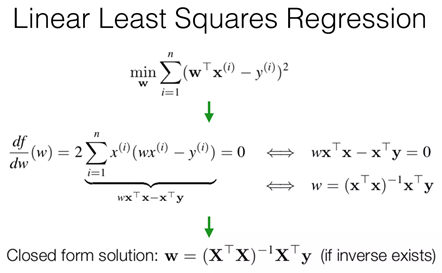

In [32]:
X = Xtrain
X_pinv = np.linalg.pinv(X)
t = Ytrain

In [33]:
print("X shape: ", X.shape)
print("t shape: ", t.shape)

X shape:  (960, 784)
t shape:  (960, 10)


In [34]:
W = np.matmul(X_pinv, t)

In [35]:
print("W: \n{}".format(W))

W: 
[[ 18.72586889   8.9588023    7.78240565 ...   5.90377614  -7.78897851
    8.20341441]
 [  9.34773079   4.027423    -1.8031176  ...  -3.22032054 -12.71218428
   -0.42909618]
 [ -5.20989856  -4.64461951   0.36369849 ...  10.29308294   5.43636634
   -9.51331748]
 ...
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


In [36]:
def L2_loss(y, y_pred):
    return np.sum((y - y_pred)**2)

### train data

In [37]:
Ytrain_pred  = np.matmul(Xtrain, W)

In [38]:
print("Ytrain_pred: ", Ytrain_pred)

Ytrain_pred:  [[ 0.04662777 -0.04654083  0.02840509 ... -0.06096644 -0.04267679
  -0.08576797]
 [ 0.90626385 -0.05968237 -0.02417275 ...  0.19345198  0.27056487
   0.0189889 ]
 [-0.0019224   0.01597558  0.06355574 ...  0.13176422 -0.12106052
  -0.17582498]
 ...
 [ 0.21506232  0.01238424 -0.05253336 ... -0.02582213 -0.17242458
  -0.07734832]
 [ 0.13306086  0.01108396  0.80546909 ... -0.01914097 -0.03132758
   0.06043091]
 [-0.02016951  0.00657587  0.12716154 ... -0.04301388 -0.10606331
   0.00778813]]


#### Loss

In [39]:
train_loss = L2_loss(Ytrain, Ytrain_pred)

In [40]:
print("Least Square Solution - Training L2 loss: %.4f"%(train_loss))

Least Square Solution - Training L2 loss: 55.7763


#### Accuracy

In [41]:
label = np.argmax(Ytrain, axis=1)
pred = np.argmax(Ytrain_pred, axis=1)

In [42]:
print("label: ", label)

label:  [6 0 6 2 8 9 3 7 1 3 5 3 7 5 5 7 7 5 0 2 5 5 4 3 5 3 1 6 9 1 6 5 4 0 1 4 0
 8 0 7 1 9 3 2 3 9 2 2 9 0 1 9 1 6 5 5 5 2 2 9 3 3 8 2 8 3 6 5 9 3 0 0 5 0
 8 4 8 0 9 4 8 1 4 2 7 7 9 0 0 9 6 3 8 6 5 2 1 8 1 8 6 9 4 1 5 1 1 8 9 2 1
 2 8 3 2 3 0 6 2 3 5 8 6 7 6 6 0 8 0 6 4 6 1 5 3 9 1 1 4 4 0 7 0 4 7 7 9 2
 3 0 9 8 5 0 8 9 2 9 6 4 0 0 5 3 3 3 6 3 4 8 2 3 1 1 9 3 5 7 1 4 4 3 3 1 3
 4 0 0 9 6 8 1 6 2 5 9 4 3 5 2 1 2 5 3 5 1 1 3 8 4 1 8 8 4 9 2 4 1 6 1 0 6
 8 5 8 2 7 0 4 0 8 5 2 2 6 0 3 1 4 9 1 9 9 0 6 7 9 0 6 6 3 8 1 6 1 2 4 0 0
 7 1 4 5 0 7 7 5 5 5 8 9 5 2 6 1 5 7 6 9 8 9 7 2 4 3 5 6 6 0 9 1 5 6 8 3 6
 9 7 2 0 7 5 2 5 6 1 7 3 7 6 7 1 0 1 5 4 2 8 0 9 5 4 3 9 4 1 7 5 1 6 6 7 0
 9 0 6 5 7 4 7 0 4 7 3 9 4 3 9 6 5 2 2 9 2 7 3 2 6 3 0 5 3 4 1 8 0 1 5 4 3
 2 4 2 9 9 4 3 9 0 8 6 9 5 0 7 5 0 8 2 9 3 8 1 5 2 8 9 6 8 8 8 7 7 5 1 6 1
 0 8 7 8 4 8 8 8 8 6 6 7 8 1 4 5 4 2 8 3 7 9 1 6 9 2 0 3 6 1 5 6 0 5 8 2 9
 8 8 6 7 8 3 2 4 6 4 6 3 7 4 7 1 2 2 4 9 3 7 8 6 4 5 0 4 2 8 5 5 1 5 2 9 6
 7 7 2 1 3 5 5 7 

In [43]:
print("pred: ", pred)

pred:  [6 0 6 2 8 9 3 7 1 3 5 3 7 5 5 7 7 5 0 2 5 5 4 3 5 3 1 6 9 1 6 5 4 0 1 4 0
 8 0 7 1 9 3 2 3 9 2 2 9 0 1 9 1 6 5 5 5 2 2 9 3 3 8 2 8 3 6 5 9 3 0 0 5 0
 8 4 8 0 9 4 8 1 4 2 7 7 9 0 0 9 6 3 8 6 5 2 1 8 1 8 6 9 4 1 5 1 1 8 9 2 1
 2 8 3 2 3 0 6 2 3 5 8 6 7 6 6 0 8 0 6 4 6 1 5 3 9 1 1 4 4 0 7 0 4 7 7 9 2
 3 0 9 8 5 0 8 9 2 9 6 4 0 0 5 3 3 3 6 3 4 8 2 3 1 1 9 3 5 7 1 4 4 3 3 1 3
 4 0 0 9 6 8 1 6 2 5 9 4 3 5 2 1 2 5 3 5 1 1 3 8 4 1 8 8 4 9 2 4 1 6 1 0 6
 8 5 8 2 7 0 4 0 8 5 2 2 6 0 3 1 4 9 1 9 9 0 6 7 9 0 6 6 3 8 1 6 1 2 4 0 0
 7 1 4 5 0 7 7 5 5 5 8 9 5 2 6 1 5 7 6 9 8 9 7 2 4 3 5 6 6 0 9 1 5 6 8 3 6
 9 7 2 0 7 5 2 5 6 1 7 3 7 6 7 1 0 1 5 4 2 8 0 9 5 4 3 9 4 1 7 5 1 6 6 7 0
 9 0 6 5 7 4 7 0 4 7 3 9 4 3 9 6 5 2 2 9 2 7 3 2 6 3 0 5 3 4 1 8 0 1 5 4 3
 2 4 2 9 9 4 3 9 0 8 6 9 5 0 7 5 0 8 2 9 3 8 1 5 2 8 9 6 8 8 8 7 7 5 1 6 1
 0 8 7 8 4 8 8 8 8 6 6 7 8 1 4 5 4 2 8 3 7 9 1 6 9 2 0 3 6 1 5 6 0 5 8 2 9
 8 8 6 7 8 3 2 4 6 4 6 3 7 4 7 1 2 2 4 9 3 7 8 6 4 5 0 4 2 8 5 5 1 5 2 9 6
 7 7 2 1 3 5 5 7 7

In [44]:
correct = 0

for i in range(len(Ytrain_pred)):
    if(pred[i] == label[i]):
        correct += 1

train_acc = correct / len(Ytrain_pred) * 100.

In [45]:
print("Least Square Solution - Training Accuracy: %.4f"%(train_acc), "%")

Least Square Solution - Training Accuracy: 100.0000 %


### test data

In [46]:
Ytest_pred  = np.matmul(Xtest, W)

#### Loss

In [47]:
test_loss = L2_loss(Ytest, Ytest_pred)

In [48]:
print("Least Square Solution - Testing L2 loss: %.4f"%(test_loss))

Least Square Solution - Testing L2 loss: 2978.3602


#### Accuracy

In [49]:
label = np.argmax(Ytest, axis=1)
pred = np.argmax(Ytest_pred, axis=1)

In [50]:
print("label: ", label)

label:  [6 0 7 1 4 7 3 2 2 7 7 4 9 1 4 2 1 0 0 5 5 2 4 8 3 4 8 7 2 3 6 5 6 4 9 2 1
 9 1 5 4 5 8 7 5 0 4 8 6 4 1 2 9 9 1 9 7 4 2 3 2 4 1 0 9 5 4 7 2 5 4 1 5 7
 5 5 0 3 1 7 3 7 9 5 2 2 9 3 6 0 2 0 3 0 0 7 3 1 6 7 2 1 5 1 0 8 3 1 4 9 6
 3 2 5 5 8 3 8 3 0 5 4 6 2 0 7 5 2 4 6 0 7 7 6 7 4 0 3 2 8 8 2 4 0 3 7 5 6
 8 3 6 6 7 5 2 1 5 4 3 0 8 5 1 4 1 2 9 9 8 1 8 8 8 8 3 4 2 3 4 9 4 0 7 3 8
 6 1 5 0 4 6 3 7 4 1 5 3 8 6 9 6 7 9 6 3 0 3 0 2 7 6 6 7 8 0 9 0 1 1 3 1 1
 9 4 8 6 8 5 3 4 1 1 8 8 4 8 8 3 9 9 9 2 8 5 4 9 8 8 0 6 2 9 7 5 2 9 7 9 3
 0 1 2 3 5 4 3 9 6 9 9 8 9 5 2 4 2 1 9 7 6 1 3 7 5 6 6 9 4 7 9 8 7 6 5 8 3
 0 1 5 0 2 1 6 6 6 5 9 7 0 6 2 1 0 2 8 6 0 0 7 0]


In [51]:
print("pred: ", pred)

pred:  [6 2 7 1 4 3 5 2 2 7 5 4 9 7 1 6 1 0 7 6 3 2 1 9 5 4 8 7 6 5 6 5 6 5 9 9 1
 3 1 9 4 5 8 9 4 3 4 8 3 1 1 2 9 1 1 9 7 8 7 3 6 1 1 0 9 5 4 9 2 5 4 1 9 9
 5 8 0 5 1 7 3 9 7 8 9 9 7 5 6 0 7 0 3 0 0 5 8 1 6 9 8 1 8 1 3 7 7 1 3 9 6
 2 7 5 4 1 5 5 3 8 8 4 6 9 0 7 2 8 0 6 7 7 9 6 7 4 0 3 5 8 8 3 0 6 3 7 6 4
 8 4 3 9 8 5 8 1 5 1 8 0 8 5 1 4 1 2 9 8 8 1 9 8 6 5 5 7 3 3 8 7 4 0 7 3 8
 9 1 5 0 4 6 3 4 7 1 1 2 0 3 9 9 7 3 6 3 0 5 8 7 4 6 6 7 8 0 5 0 1 1 6 1 7
 8 4 8 6 9 2 7 1 1 1 8 9 4 8 9 5 3 9 7 3 4 0 8 5 8 8 0 6 2 0 4 5 9 7 8 7 3
 0 1 8 3 8 4 4 9 0 9 3 1 9 5 9 5 8 1 9 7 6 1 8 3 7 9 0 9 9 7 5 1 1 1 7 5 4
 0 1 8 0 7 1 9 6 6 5 7 9 0 6 3 8 8 9 4 6 0 0 3 0]


In [52]:
correct = 0

for i in range(len(Ytest_pred)):
    if(pred[i] == label[i]):
        correct += 1

test_acc = correct / len(Ytest_pred) * 100.

In [53]:
print("Least Square Solution - Testing Accuracy: %.4f"%(test_acc), "%")

Least Square Solution - Testing Accuracy: 50.9375 %


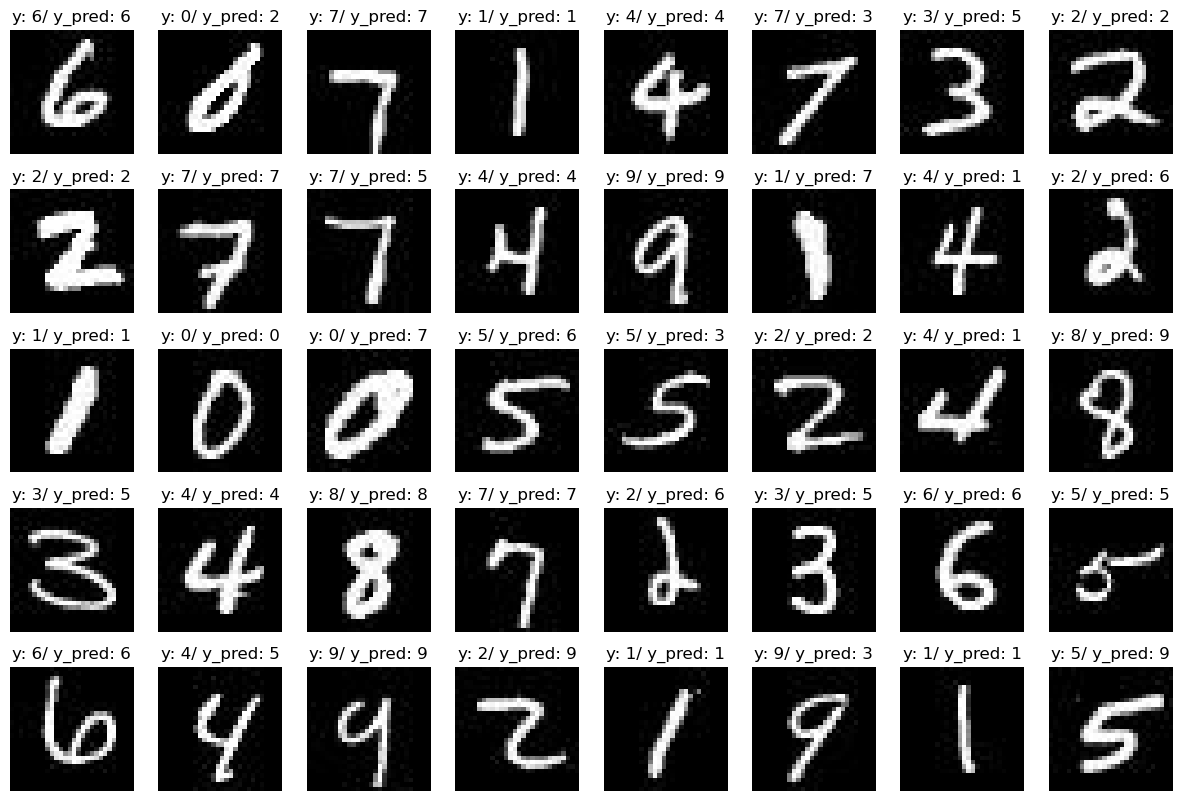

In [54]:
fig = plt.figure(figsize=(15,10))
for i in range(40):  
    ax = fig.add_subplot(5, 8, i+1)
    ax.imshow(Xtest[i].reshape(28,28), cmap='gray')
    
    ax.set_title('y: {y}/ y_pred: {y_pred}'.format(y=label[i], y_pred=pred[i]))
    plt.axis('off')

In [55]:
print("[Training data]")
print("Least Square Solution - L2 loss: %.4f"%(train_loss))
print("Least Square Solution - Accuracy: %.4f"%(train_acc), "%")
print("--------------------------------------------")
print("[Testing data]")
print("Least Square Solution - L2 loss: %.4f"%(test_loss))
print("Least Square Solution - Accuracy: %.4f"%(test_acc), "%")

[Training data]
Least Square Solution - L2 loss: 55.7763
Least Square Solution - Accuracy: 100.0000 %
--------------------------------------------
[Testing data]
Least Square Solution - L2 loss: 2978.3602
Least Square Solution - Accuracy: 50.9375 %


----

### 1.2 Logistic Regression

In [56]:
def data_iter(batch_size, features, labels):
    n_examples = len(features)
    indices = list(range(n_examples))
    random.shuffle(indices)
    
    for i in range(0, n_examples, batch_size):
        batch_indices = np.array(indices[i: min(i + batch_size, n_examples)])
        yield features[batch_indices], labels[batch_indices]

In [57]:
def softmax(z):
    exp = np.exp(z - np.max(z))
    
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
    
    return exp

In [58]:
def logistic_regression(x, w):
    z = x@w
    y_pred = softmax(z)
    
    return y_pred

In [59]:
def predict(x, w):
    y_pred = logistic_regression(x, w)
    
    return np.argmax(y_pred, axis=1)

In [60]:
def cross_entropy(y, y_pred):
    loss = -np.sum((y * np.log(y_pred)))
    
    return loss

In [61]:
def accuracy(y, y_pred):
    acc = np.sum(y==y_pred) #/len(y)
    
    return acc

In [62]:
def train(Xtrain, Ytrain, Xtest, Ytest, lr, epochs, train_batch_size, test_batch_size, n_classes):
    train_loss = []
    test_loss =[]
    train_acc = []
    test_acc = []
    best_acc = 0.
    total_loss = 0.
    total_correct = 0
    
    # m: number of examples
    # n: number of features
    m, n = Xtrain.shape

    # Initialize the weights and bias
    w = np.zeros((n, n_classes))
    best_weights = np.zeros((n, n_classes))
    
    print('------------- Start Training -------------')
    
    for epoch in range(1, epochs+1): 
        print('------------- Epoch [{}/{}] -------------'.format(epoch, epochs))
            
        for phase in ['train', 'test']:
            if phase == 'train':
                total_loss = 0.0
                total_correct = 0
                for x, y in data_iter(train_batch_size, Xtrain, Ytrain):
                    m, _ = x.shape
                    
                    ### forward ###
                    # Logistic regression
                    y_pred = logistic_regression(x, w)
                    
                    # Calculate cross entropy loss
                    loss = cross_entropy(y, y_pred)
                    
                    ### backward + optimize ###
                    # Calculate the gradient
                    w_grad = (1/m)*np.dot(x.T, (y_pred - y))

                    # Update the parameters
                    w = w - lr * w_grad / train_batch_size
                
                    # statistics
                    total_loss += loss
                    
                    label = np.argmax(y, axis=1)
                    pred = predict(x, w)
                    
                    total_correct += np.sum(pred==label)
                    
                avg_loss = total_loss / len(Ytrain)
                acc = total_correct* 100. / len(Ytrain) 
                
                train_loss.append(avg_loss)
                train_acc.append(acc)
                print("[Training] Loss %.4f | Accuracy %.4f" %(avg_loss, acc))
            
            elif phase == 'test':
                total_loss = 0.0
                total_correct = 0
                for x, y in data_iter(test_batch_size, Xtest, Ytest):
                    m, _ = x.shape
                    ### forward ###
                    # Logistic regression
                    y_pred = logistic_regression(x, w)
                    
                    # Calculate cross entropy loss
                    loss = np.sum(cross_entropy(y, y_pred))
                    
                    # statistics
                    total_loss += loss
                    
                    label = np.argmax(y, axis=1)
                    pred = predict(x, w)
                    
                    total_correct += np.sum(pred==label)
                
                avg_loss = total_loss / len(Ytest)
                acc = total_correct*100. / len(Ytest) 
                
                test_loss.append(avg_loss)
                test_acc.append(acc)
                print("[Testing]  Loss %.4f | Accuracy %.4f \n" %(avg_loss, acc))
                
                if acc > best_acc:
                    best_acc = acc
                    best_weights = w
    
    return train_loss, test_loss, train_acc, test_acc, best_weights

In [63]:
n_classes = 10
epochs = 1000

batch_size = 32
train_batch_size = batch_size
test_batch_size = batch_size

lr = 0.01

In [64]:
# Trainig
train_loss, test_loss, train_acc, test_acc, best_weights = train(Xtrain, Ytrain, Xtest, Ytest, lr, epochs, train_batch_size, test_batch_size, n_classes)

------------- Start Training -------------
------------- Epoch [1/1000] -------------
[Training] Loss 2.2980 | Accuracy 51.3542
[Testing]  Loss 2.2928 | Accuracy 57.8125 

------------- Epoch [2/1000] -------------
[Training] Loss 2.2878 | Accuracy 65.7292
[Testing]  Loss 2.2832 | Accuracy 58.1250 

------------- Epoch [3/1000] -------------
[Training] Loss 2.2777 | Accuracy 63.6458
[Testing]  Loss 2.2737 | Accuracy 59.0625 

------------- Epoch [4/1000] -------------
[Training] Loss 2.2677 | Accuracy 63.3333
[Testing]  Loss 2.2642 | Accuracy 59.6875 

------------- Epoch [5/1000] -------------
[Training] Loss 2.2578 | Accuracy 62.6042
[Testing]  Loss 2.2549 | Accuracy 61.5625 

------------- Epoch [6/1000] -------------
[Training] Loss 2.2480 | Accuracy 65.2083
[Testing]  Loss 2.2456 | Accuracy 61.8750 

------------- Epoch [7/1000] -------------
[Training] Loss 2.2383 | Accuracy 64.2708
[Testing]  Loss 2.2364 | Accuracy 62.8125 

------------- Epoch [8/1000] -------------
[Training] 

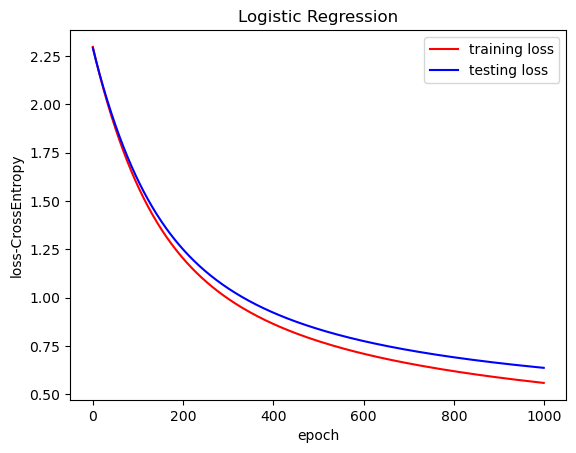

In [65]:
plt.title("Logistic Regression")

plt.ylabel("loss-CrossEntropy")
plt.xlabel("epoch")

plt.plot(train_loss, linestyle='solid', color='red', label='loss')

plt.plot(test_loss, linestyle='solid', color='blue', label='loss')
plt.legend(['training loss','testing loss'],loc='upper right')

plt.show()

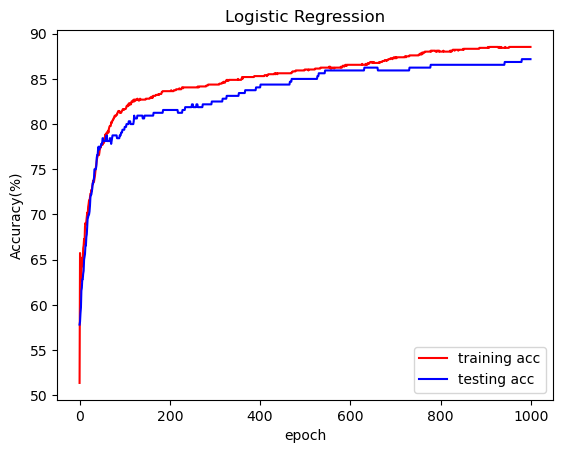

In [66]:
plt.title("Logistic Regression")

plt.ylabel("Accuracy(%)")
plt.xlabel("epoch")

plt.plot(train_acc, linestyle='solid', color='red', label='loss')

plt.plot(test_acc, linestyle='solid', color='blue', label='loss')
plt.legend(['training acc','testing acc'],loc='lower right')

plt.show()

In [67]:
pred = predict(Xtest, best_weights)

In [68]:
print("Ground truth: ")
test_ground_truth = np.argmax(Ytest, axis=1)
print(test_ground_truth)

Ground truth: 
[6 0 7 1 4 7 3 2 2 7 7 4 9 1 4 2 1 0 0 5 5 2 4 8 3 4 8 7 2 3 6 5 6 4 9 2 1
 9 1 5 4 5 8 7 5 0 4 8 6 4 1 2 9 9 1 9 7 4 2 3 2 4 1 0 9 5 4 7 2 5 4 1 5 7
 5 5 0 3 1 7 3 7 9 5 2 2 9 3 6 0 2 0 3 0 0 7 3 1 6 7 2 1 5 1 0 8 3 1 4 9 6
 3 2 5 5 8 3 8 3 0 5 4 6 2 0 7 5 2 4 6 0 7 7 6 7 4 0 3 2 8 8 2 4 0 3 7 5 6
 8 3 6 6 7 5 2 1 5 4 3 0 8 5 1 4 1 2 9 9 8 1 8 8 8 8 3 4 2 3 4 9 4 0 7 3 8
 6 1 5 0 4 6 3 7 4 1 5 3 8 6 9 6 7 9 6 3 0 3 0 2 7 6 6 7 8 0 9 0 1 1 3 1 1
 9 4 8 6 8 5 3 4 1 1 8 8 4 8 8 3 9 9 9 2 8 5 4 9 8 8 0 6 2 9 7 5 2 9 7 9 3
 0 1 2 3 5 4 3 9 6 9 9 8 9 5 2 4 2 1 9 7 6 1 3 7 5 6 6 9 4 7 9 8 7 6 5 8 3
 0 1 5 0 2 1 6 6 6 5 9 7 0 6 2 1 0 2 8 6 0 0 7 0]


In [69]:
print("Predict: ")
test_predict = np.array(pred)
print(test_predict)

Predict: 
[6 2 7 1 9 7 3 2 2 7 7 4 9 1 1 2 1 0 0 5 5 2 4 8 3 4 8 7 6 3 6 8 6 4 9 7 1
 9 1 5 9 5 8 7 5 0 9 8 6 9 1 2 9 9 1 9 7 2 1 3 2 4 1 0 9 5 4 7 2 5 4 1 5 7
 5 5 0 3 1 7 3 7 9 5 2 2 9 3 6 0 2 0 3 0 0 7 3 1 6 7 2 1 5 1 0 3 3 2 4 9 6
 3 3 5 9 3 3 8 3 0 0 4 6 2 0 7 3 1 4 6 0 7 7 6 7 4 0 3 8 8 8 2 4 0 3 7 5 6
 8 3 6 6 1 5 8 1 5 1 3 0 8 5 1 4 1 2 9 9 8 1 8 8 8 8 3 4 2 3 9 9 4 0 7 3 8
 6 1 8 0 4 6 3 7 4 1 5 3 8 6 9 6 7 9 6 3 0 3 5 2 7 6 6 7 8 0 9 0 1 1 3 1 1
 9 4 8 6 8 4 3 4 1 1 8 8 4 8 8 3 4 9 9 2 5 5 4 8 8 8 0 2 2 9 7 5 2 9 7 4 3
 0 1 2 3 5 4 3 9 6 9 7 8 9 5 0 9 2 1 9 1 6 1 3 7 4 6 6 9 4 7 4 9 1 6 5 8 3
 0 1 5 0 2 1 6 6 6 5 9 7 0 6 2 1 0 4 8 6 0 0 7 0]


In [70]:
print("[Training]")
print("Logistic Regression - Final Loss: %.4f"%(train_loss[-1]))
print("Logistic Regression - Final Accuracy: %.4f"%(train_acc[-1]), "%")
print("--------------------------------------------")
print("[Testing]")
print("Logistic Regression - Final Loss: %.4f"%(test_loss[-1]))
print("Logistic Regression - Final Accuracy: %.4f"%(test_acc[-1]), "%")

[Training]
Logistic Regression - Final Loss: 0.5584
Logistic Regression - Final Accuracy: 88.5417 %
--------------------------------------------
[Testing]
Logistic Regression - Final Loss: 0.6365
Logistic Regression - Final Accuracy: 87.1875 %


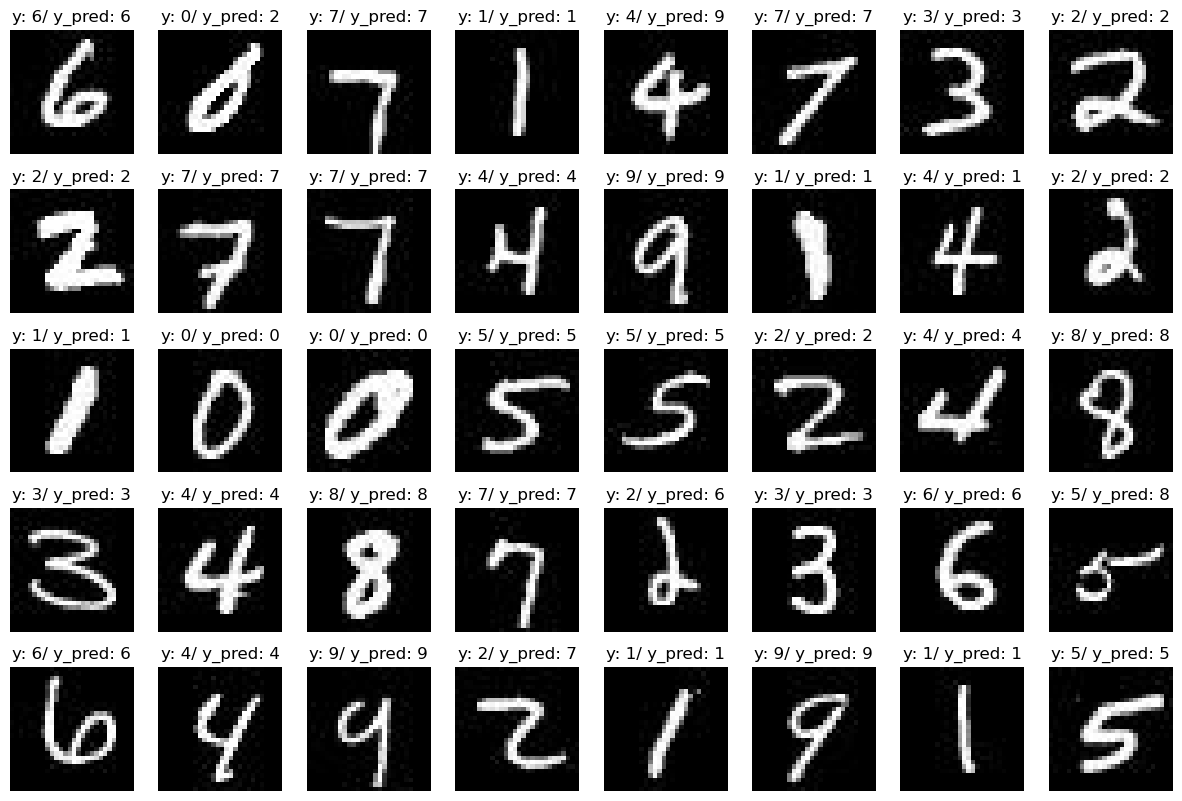

In [71]:
fig = plt.figure(figsize=(15,10))
for i in range(40):  
    ax = fig.add_subplot(5, 8, i+1)
    ax.imshow(Xtest[i].reshape(28,28), cmap='gray')
    
    ax.set_title('y: {y}/ y_pred: {y_pred}'.format(y=test_ground_truth[i], y_pred=test_predict[i]))
    plt.axis('off')

------------------------

#### Batch GD / batch_size = N

In [72]:
n_classes = 10
epochs = 1000

batch_size = 32
train_batch_size = batch_size
test_batch_size = batch_size

lr = 0.01

In [73]:
# Trainig
train_loss, test_loss, train_acc, test_acc, best_weights = train(Xtrain, Ytrain, Xtest, Ytest, lr, epochs, train_batch_size, test_batch_size, n_classes)

------------- Start Training -------------
------------- Epoch [1/1000] -------------
[Training] Loss 2.2980 | Accuracy 45.8333
[Testing]  Loss 2.2928 | Accuracy 57.5000 

------------- Epoch [2/1000] -------------
[Training] Loss 2.2878 | Accuracy 67.5000
[Testing]  Loss 2.2832 | Accuracy 58.1250 

------------- Epoch [3/1000] -------------
[Training] Loss 2.2777 | Accuracy 64.1667
[Testing]  Loss 2.2737 | Accuracy 59.0625 

------------- Epoch [4/1000] -------------
[Training] Loss 2.2677 | Accuracy 64.0625
[Testing]  Loss 2.2642 | Accuracy 60.0000 

------------- Epoch [5/1000] -------------
[Training] Loss 2.2578 | Accuracy 63.3333
[Testing]  Loss 2.2549 | Accuracy 61.2500 

------------- Epoch [6/1000] -------------
[Training] Loss 2.2480 | Accuracy 65.4167
[Testing]  Loss 2.2456 | Accuracy 61.8750 

------------- Epoch [7/1000] -------------
[Training] Loss 2.2383 | Accuracy 64.2708
[Testing]  Loss 2.2364 | Accuracy 62.8125 

------------- Epoch [8/1000] -------------
[Training] 

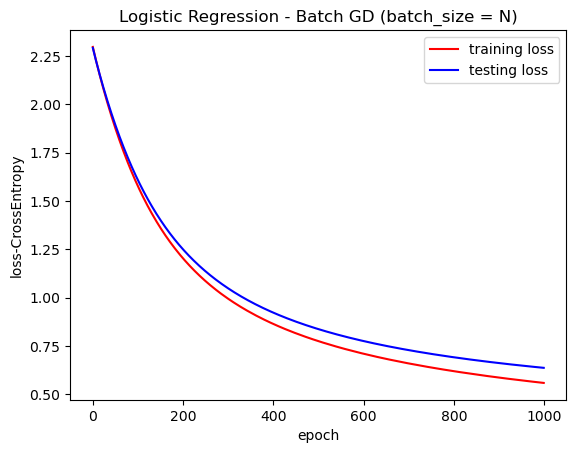

In [74]:
plt.title("Logistic Regression - Batch GD (batch_size = N)")

plt.ylabel("loss-CrossEntropy")
plt.xlabel("epoch")

plt.plot(train_loss, linestyle='solid', color='red', label='loss')

plt.plot(test_loss, linestyle='solid', color='blue', label='loss')
plt.legend(['training loss','testing loss'],loc='upper right')

plt.show()

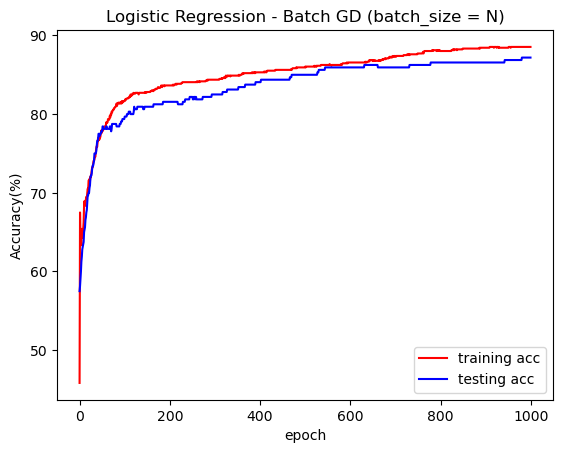

In [75]:
plt.title("Logistic Regression - Batch GD (batch_size = N)")

plt.ylabel("Accuracy(%)")
plt.xlabel("epoch")

plt.plot(train_acc, linestyle='solid', color='red', label='loss')

plt.plot(test_acc, linestyle='solid', color='blue', label='loss')
plt.legend(['training acc','testing acc'],loc='lower right')

plt.show()

In [76]:
print("[Training]")
print("Logistic Regression w/ BGD - Final Loss: %.4f"%(train_loss[-1]))
print("Logistic Regression w/ BGD - Final Accuracy: %.4f"%(train_acc[-1]), "%")
print("--------------------------------------------")
print("[Testing]")
print("Logistic Regression w/ BGD - Final Loss: %.4f"%(test_loss[-1]))
print("Logistic Regression w/ BGD- Final Accuracy: %.4f"%(test_acc[-1]), "%")

[Training]
Logistic Regression w/ BGD - Final Loss: 0.5584
Logistic Regression w/ BGD - Final Accuracy: 88.5417 %
--------------------------------------------
[Testing]
Logistic Regression w/ BGD - Final Loss: 0.6365
Logistic Regression w/ BGD- Final Accuracy: 87.1875 %


-----------

#### SGD / batch_size = 1

In [77]:
n_classes = 10
epochs = 1000

batch_size = 1
train_batch_size = batch_size
test_batch_size = batch_size

lr = 0.01

In [78]:
# Trainig
train_loss, test_loss, train_acc, test_acc, best_weights = train(Xtrain, Ytrain, Xtest, Ytest, lr, epochs, train_batch_size, test_batch_size, n_classes)

------------- Start Training -------------
------------- Epoch [1/1000] -------------
[Training] Loss 1.0418 | Accuracy 91.0417
[Testing]  Loss 0.6425 | Accuracy 85.0000 

------------- Epoch [2/1000] -------------
[Training] Loss 0.5143 | Accuracy 94.8958
[Testing]  Loss 0.5188 | Accuracy 86.5625 

------------- Epoch [3/1000] -------------
[Training] Loss 0.4028 | Accuracy 96.1458
[Testing]  Loss 0.5138 | Accuracy 86.8750 

------------- Epoch [4/1000] -------------
[Training] Loss 0.3398 | Accuracy 96.8750
[Testing]  Loss 0.4493 | Accuracy 88.1250 

------------- Epoch [5/1000] -------------
[Training] Loss 0.2942 | Accuracy 97.9167
[Testing]  Loss 0.4288 | Accuracy 88.1250 

------------- Epoch [6/1000] -------------
[Training] Loss 0.2670 | Accuracy 98.1250
[Testing]  Loss 0.4322 | Accuracy 86.2500 

------------- Epoch [7/1000] -------------
[Training] Loss 0.2434 | Accuracy 98.5417
[Testing]  Loss 0.4335 | Accuracy 87.5000 

------------- Epoch [8/1000] -------------
[Training] 

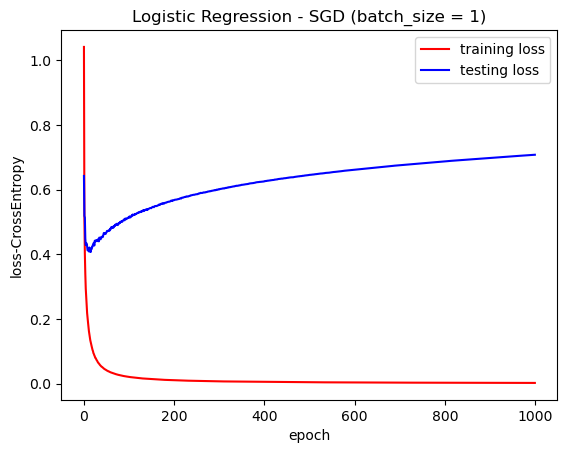

In [79]:
plt.title("Logistic Regression - SGD (batch_size = 1)")

plt.ylabel("loss-CrossEntropy")
plt.xlabel("epoch")

plt.plot(train_loss, linestyle='solid', color='red', label='loss')

plt.plot(test_loss, linestyle='solid', color='blue', label='loss')
plt.legend(['training loss','testing loss'],loc='upper right')

plt.show()

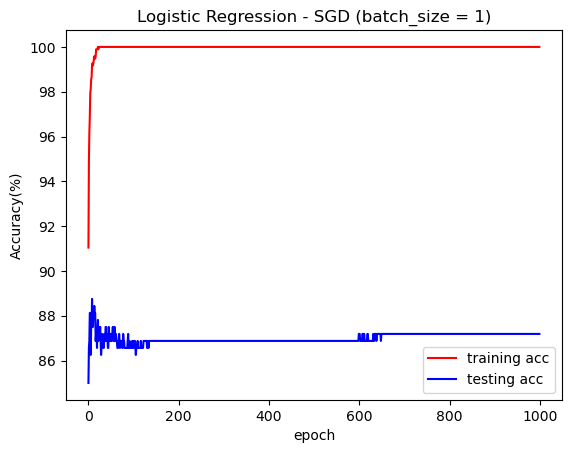

In [80]:
plt.title("Logistic Regression - SGD (batch_size = 1)")

plt.ylabel("Accuracy(%)")
plt.xlabel("epoch")

plt.plot(train_acc, linestyle='solid', color='red', label='loss')

plt.plot(test_acc, linestyle='solid', color='blue', label='loss')
plt.legend(['training acc','testing acc'],loc='lower right')

plt.show()

In [81]:
print("[Training]")
print("Logistic Regression w/ SGD - Final Loss: %.4f"%(train_loss[-1]))
print("Logistic Regression w/ SGD - Final Accuracy: %.4f"%(train_acc[-1]), "%")
print("--------------------------------------------")
print("[Testing]")
print("Logistic Regression w/ SGD - Final Loss: %.4f"%(test_loss[-1]))
print("Logistic Regression w/ SGD- Final Accuracy: %.4f"%(test_acc[-1]), "%")

[Training]
Logistic Regression w/ SGD - Final Loss: 0.0021
Logistic Regression w/ SGD - Final Accuracy: 100.0000 %
--------------------------------------------
[Testing]
Logistic Regression w/ SGD - Final Loss: 0.7081
Logistic Regression w/ SGD- Final Accuracy: 87.1875 %


---------------

#### Mini-batch SGD / batch_size = B

In [82]:
n_classes = 10
epochs = 1000

batch_size = 4
train_batch_size = batch_size
test_batch_size = batch_size

lr = 0.01

In [83]:
# Trainig
train_loss, test_loss, train_acc, test_acc, best_weights = train(Xtrain, Ytrain, Xtest, Ytest, lr, epochs, train_batch_size, test_batch_size, n_classes)

------------- Start Training -------------
------------- Epoch [1/1000] -------------
[Training] Loss 2.0446 | Accuracy 72.6042
[Testing]  Loss 1.8103 | Accuracy 77.5000 

------------- Epoch [2/1000] -------------
[Training] Loss 1.6205 | Accuracy 80.8333
[Testing]  Loss 1.4874 | Accuracy 80.9375 

------------- Epoch [3/1000] -------------
[Training] Loss 1.3423 | Accuracy 84.0625
[Testing]  Loss 1.2719 | Accuracy 82.1875 

------------- Epoch [4/1000] -------------
[Training] Loss 1.1552 | Accuracy 83.9583
[Testing]  Loss 1.1237 | Accuracy 83.4375 

------------- Epoch [5/1000] -------------
[Training] Loss 1.0244 | Accuracy 85.3125
[Testing]  Loss 1.0179 | Accuracy 82.1875 

------------- Epoch [6/1000] -------------
[Training] Loss 0.9276 | Accuracy 85.2083
[Testing]  Loss 0.9385 | Accuracy 84.6875 

------------- Epoch [7/1000] -------------
[Training] Loss 0.8550 | Accuracy 86.2500
[Testing]  Loss 0.8758 | Accuracy 85.0000 

------------- Epoch [8/1000] -------------
[Training] 

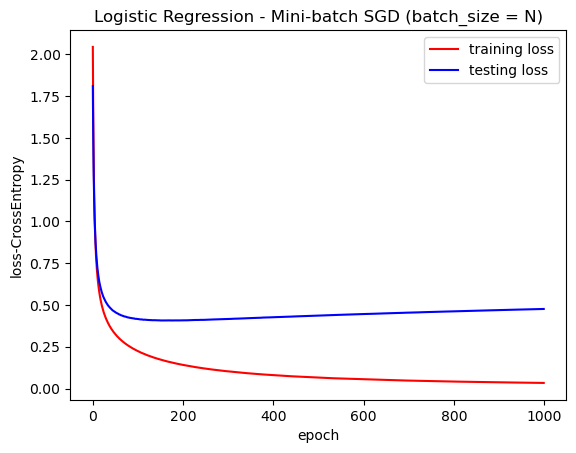

In [84]:
plt.title("Logistic Regression - Mini-batch SGD (batch_size = N)")

plt.ylabel("loss-CrossEntropy")
plt.xlabel("epoch")

plt.plot(train_loss, linestyle='solid', color='red', label='loss')

plt.plot(test_loss, linestyle='solid', color='blue', label='loss')
plt.legend(['training loss','testing loss'],loc='upper right')

plt.show()

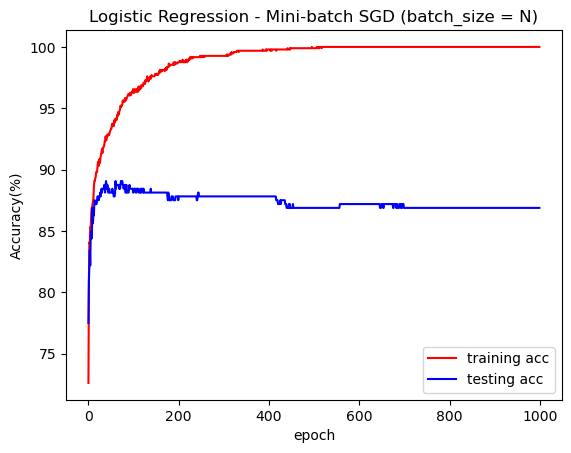

In [85]:
plt.title("Logistic Regression - Mini-batch SGD (batch_size = N)")

plt.ylabel("Accuracy(%)")
plt.xlabel("epoch")

plt.plot(train_acc, linestyle='solid', color='red', label='loss')

plt.plot(test_acc, linestyle='solid', color='blue', label='loss')
plt.legend(['training acc','testing acc'],loc='lower right')

plt.show()

In [86]:
print("[Training]")
print("Logistic Regression w/ MBGD - Final Loss: %.4f"%(train_loss[-1]))
print("Logistic Regression w/ MBGD - Final Accuracy: %.4f"%(train_acc[-1]), "%")
print("--------------------------------------------")
print("[Testing]")
print("Logistic Regression w/ MBGD - Final Loss: %.4f"%(test_loss[-1]))
print("Logistic Regression w/ MBGD- Final Accuracy: %.4f"%(test_acc[-1]), "%")

[Training]
Logistic Regression w/ MBGD - Final Loss: 0.0337
Logistic Regression w/ MBGD - Final Accuracy: 100.0000 %
--------------------------------------------
[Testing]
Logistic Regression w/ MBGD - Final Loss: 0.4763
Logistic Regression w/ MBGD- Final Accuracy: 86.8750 %


(c) Based on your observation about the different algorithms (batch GD, SGD, and mini-batch SGD),  please make some discussion.

Gradient descent(梯度下降法)是一種透過迭代來優化並更新參數的機器學習算法，用於降低cost function，以便訓練出能夠更精準預測的模型。Batch GD是一個epoch使用全部的data去計算損失函數，並更新一次參數(一個epoch更新一次參數)。SGD是一次使用一個樣本(example)，然後算出損失函數，並更新參數(一筆example更新一次參數)。Mini-batch GD就是介於Batch GD與SGD之間，會設定一個batch size，一次拿batch size大小的data數量去計算損失函數，然後更新一次參數。

由於Batch GD是一個epoch更新一次參數，SGD是每看一筆資料就更新一次參數。因此一個epoch的訓練時間，SGD執行時間會比Batch GD來得長。
訓練一個epoch的所需的時間：SGD > Mini-batch GD > Batch GD

由於SGD是針對個體資料去對模型做優化，因此在學習率(learning rate)太大時，容易造成參數更新呈現鋸齒狀，learning curve的loss與accuracy會有較大的震盪，除此之外，容易導致overfitting使模型泛化能力下降。Batch GD是看完整個dataset之後做優化，因此learning curve會比較平滑，訓練比較有效率，模型泛化能力高，能夠適應testing data。
模型收斂效率：Batch GD > Mini-batch GD > SGD
模型泛化能力：Batch GD > Mini-batch GD > SGD

由於SGD是一筆資料更新一次，所以一個epoch會更新比Batch GD還多次。因此，在相同epoch下SGD收斂較快。
相同epoch下模型收斂速度：SGD > Mini-batch GD > Batch GD


---

### 1.3 Make some discussion about the difference between the results of 1.1 and 1.2.

Least squares method(最小平方法)主要要是透過最小化誤差的平方來求解出最佳參數。假設X有Full rank，就有closed-form soluton，但現實是equation的數量往往大於未知數的數量(m > n)，導致沒有解。所以利用矩陣運算，求出x的psuedo inverse來反推原本的線性方程式中的解。由於Least squares method是去擬合 traing dataset，再加上由於全部的運算都是線性的轉換，因此無法學習到非線性關係。所以導致在training上有很好的結果，testing的表現就很差，泛化能力差。

Gradient descent(梯度下降法)是透過迭代來尋找局部最佳解，透過一步一步更新權重來優化模型。使用losgistic regression使用softmax非線性函數，所以在非線性資料的表達上會比Least squares method還來的好一點。因此整體來看在testing dataset上，使用logist regressin model搭配gradient descent表現比Least squares method來的好。


----

## 2 Gaussian Process for Regression

### Step 1: Load Data

In [87]:
x_path = './gaussian_process/x.csv'
t_path = './gaussian_process/t.csv'

In [88]:
# Loade Data
dataset_X = pd.read_csv(x_path, header=None)
dataset_T = pd.read_csv(t_path, header=None)

In [89]:
dataset_X.head()

,0
0,4.520904
1,8.877857
2,7.085027
3,5.681220
4,9.007329


In [90]:
dataset_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [91]:
dataset_T.head()

,0
0,-7.643232
1,2.681281
2,3.082743
3,-2.845291
4,3.751909


In [92]:
dataset_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [93]:
n_train = 150

x = np.array(dataset_X)
t = np.array(dataset_T)

train_x = x[:n_train]
train_t = t[:n_train]

test_x = x[n_train:]
test_t = t[n_train:]

In [94]:
print("train_x size: ", len(train_x))
print("train_t size: ", len(train_t))

print("test_x size: ", len(test_x))
print("test_t size: ", len(test_t))

train_x size:  150
train_t size:  150
test_x size:  150
test_t size:  150


-----

### 1 Construct a kernel function using the basis functions and implement the Gaussian process for regression

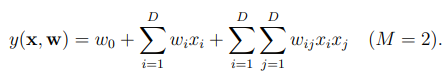

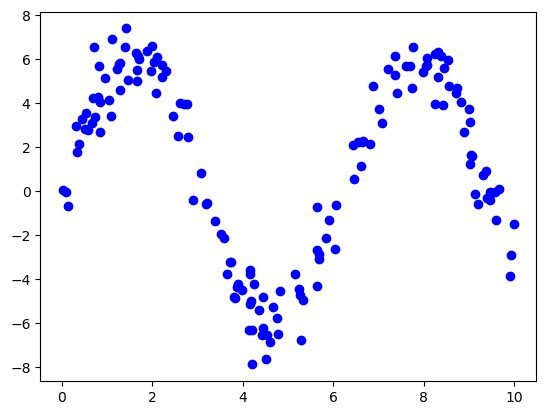

In [95]:
plt.scatter(train_x, train_t, color = 'blue', marker = 'o')

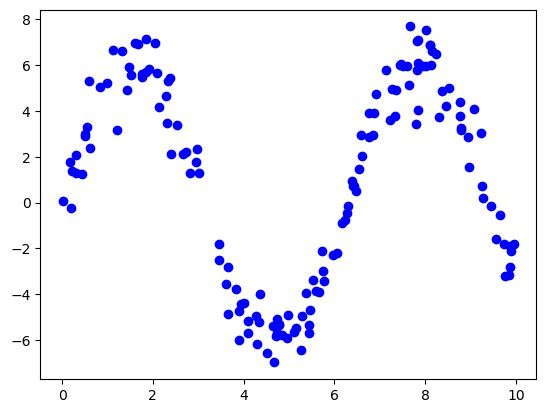

In [96]:
plt.scatter(test_x, test_t, color = 'blue', marker = 'o')

In [97]:
D = 1
n_train = 150
n_test = 150

In [98]:
# Calculate mean & variance
mu = np.zeros((D,1))
variance = np.zeros((D,1))

for i in range(0,D):
    mu[i] = np.sum(train_x[:n_train,i]) / n_train
    
for i in range(0,D):
    variance[i] = np.sum((train_x[:n_train,i] - mu[i])**2) / n_train

# Expand arrays
mu_train = np.tile(mu,(1,n_train))
mu_test = np.tile(mu,(1,n_test))
variance_train = np.tile(variance,(1,n_train))
variance_test = np.tile(variance,(1,n_test))

In [99]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = np.exp(-((train_x.T - mu_train)**2) / (2*variance_train))
matrix2_test = np.exp(-((test_x.T - mu_test)**2) / (2*variance_test))
matrix3_train = np.zeros((D**2,n_train))

In [100]:
for i in range(0,n_train):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_train[m,i] = np.exp(-(((train_x[i,j] - mu[j])**2 / (2*variance[j])) + ((train_x[i,k] - mu[k])**2 / (2*variance[k]))))
            m = m + 1
            
matrix3_test = np.zeros((D**2,n_test))

for i in range(0,n_test):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_test[m,i] = np.exp(-(((train_x[i,j] - mu[j])**2 / (2*variance[j])) + ((train_x[i,k] - mu[k])**2 / (2*variance[k]))))
            m = m + 1
            
phi_matrix_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))

In [101]:
def weight(phi, t):
    w = np.dot(np.dot(np.linalg.pinv(np.dot(phi, phi.T)), phi),t)
    return w

In [102]:
def rms(n, w, phi, t):
    rms = (np.sum((np.dot(w.T, phi) - t.T)**2) / n)**0.5
    return rms

In [103]:
# Weight for M = 2
w_M2 = weight(phi_matrix_train, train_t)

# RMS (training)
RMS_M2_train = rms(n_train, w_M2, phi_matrix_train, train_t)

# RMS (testing)
RMS_M2_test = rms(n_test, w_M2, phi_matrix_test, train_t)

In [104]:
print("[RMS Error]")
print("Training data: ", RMS_M2_train)
print("Testing data:  ", RMS_M2_test)

[RMS Error]
Training data:  1.0344234037145343
Testing data:   26.58374398546768


In [105]:
train_x.shape

(150, 1)

In [106]:
x = np.arange(0, 10, 0.01).reshape(-1, 1)

In [107]:
n_train = x.size

In [108]:
# Calculate mean & variance
mu = np.zeros((D,1))
variance = np.zeros((D,1))

for i in range(0,D):
    mu[i] = np.sum(x[:n_train,i]) / n_train
    
for i in range(0,D):
    variance[i] = np.sum((x[:n_train,i] - mu[i])**2) / n_train

# Expand arrays
mu_train = np.tile(mu,(1,n_train))
variance_train = np.tile(variance,(1,n_train))

In [109]:
matrix1_train = np.ones([1, n_train])
matrix2_train = np.exp(-((x.T - mu_train)**2) / (2*variance_train))
matrix3_train = np.zeros((D**2,n_train))

In [110]:
for i in range(0,n_train):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_train[m,i] = np.exp(-(((x[i,j] - mu[j])**2 / (2*variance[j])) + ((x[i,k] - mu[k])**2 / (2*variance[k]))))
            m = m + 1
            
matrix3_test = np.zeros((D**2,n_test))

for i in range(0,n_test):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_test[m,i] = np.exp(-(((x[i,j] - mu[j])**2 / (2*variance[j])) + ((x[i,k] - mu[k])**2 / (2*variance[k]))))
            m = m + 1
            
phi_matrix_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))

In [111]:
y = np.dot(w_M2.T, phi_matrix_train).squeeze()

In [112]:
std = np.std(y)

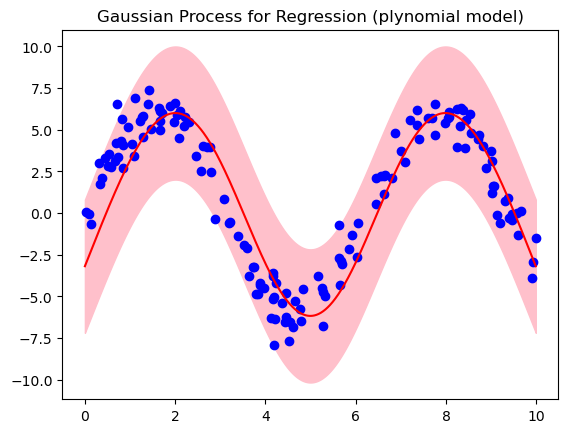

In [113]:
plt.fill_between(x.squeeze(), y - std, y + std, color = 'pink')
plt.scatter(train_x, train_t, color = 'blue', marker = 'o')
plt.plot(x, y, color='red')
plt.title("Gaussian Process for Regression (plynomial model)")
plt.show()

-------

### 2 Exponential-quadratic kernel function

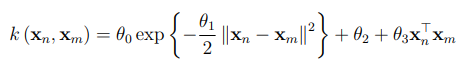

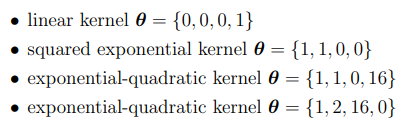

In [114]:
theta_lk = [0, 0, 0, 1]    # linear kernel
theta_sek = [1, 1, 0, 0]   # squared exponential kernel
theta_eqk1 = [1, 1, 0, 16] # exponential-quadratic kernel
theta_eqk2 = [1, 2, 16, 0]

In [115]:
from math import e, sqrt

# Exponential quadratic kernel function 
def CN(theta, X):
    c = np.zeros([150, 150])
    for n in range(150):
        for m in range(150):
            c[n][m] = theta[0] * (e ** (-0.5 * theta[1] * ((X[n] - X[m]) ** 2))) + theta[2] + theta[3] * X[n] * X[m]
            if n == m:
                c[n][m] += 1
    return c

In [116]:
def GP(theta, X, cov):
    k = np.zeros(150)
    for n in range(150):
        k[n] = theta[0] * (e ** (-theta[1] / 2 * ((X - train_x[n]) ** 2)) ) + theta[2] + theta[3] * X * train_x[n]
    k = np.reshape(k,(150,1))
    c = theta[0] * (e ** (-0.5 * theta[1] * ((X - X) ** 2)) ) + theta[2] + theta[3] * X * X
    c += 1
    cov_inv = np.linalg.inv(cov)
    p = c - np.dot(k.T,np.dot(cov_inv,k))
    mean = np.dot(k.T,np.dot(cov_inv,train_t))
    return p, mean

In [117]:
def pred(theta, Cn):
    X = np.arange(0, 10, 0.01)
    Y = np.empty(0)
    std = np.empty(0)
    for xn in X:
        p, mean = GP(theta, xn, Cn)
        Y = np.append(Y, mean)
        std = np.append(std, sqrt(p))
    plt.plot(X, Y, color = 'red')
    plt.fill_between(X, Y - std, Y + std, color = 'pink')
    plt.scatter(train_x, train_t, color = 'blue', marker = 'o')
    plt.title("theta = {}".format(theta))
    plt.show()

In [118]:
def RMSE(theta, cov):
    rmse_train = 0
    rmse_test = 0
    
    for i in range(150):
        p, mean = GP(theta, train_x[i], cov)
        rmse_train += (mean - train_t[i]) ** 2
        
    for i in range(150):
        p, mean = GP(theta, test_x[i], cov)
        rmse_test += (mean - test_t[i]) ** 2  
    rmse_train = sqrt(rmse_train/150)
    rmse_test = sqrt(rmse_test/150)
    print("theta = {}".format(theta))
    print("[RMS Error]")
    print ('Training data: ',rmse_train)
    print ('Testing data: ',rmse_test)

#### theta = [0, 0, 0 1]

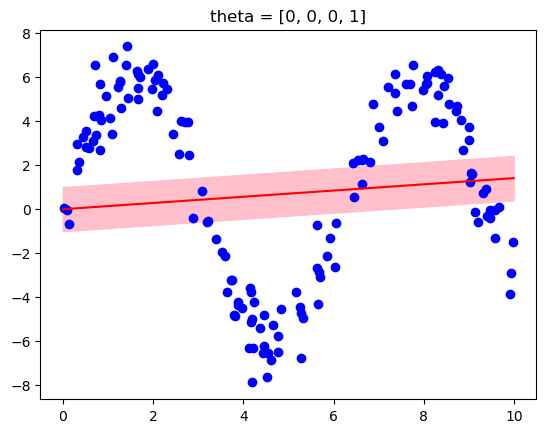

theta = [0, 0, 0, 1]
[RMS Error]
Training data:  4.33557961185875
Testing data:  4.378509014389943


In [119]:
c = CN(theta_lk, train_x)
pred(theta_lk,c)
RMSE(theta_lk, c)

#### theta = [1, 1, 0, 0]

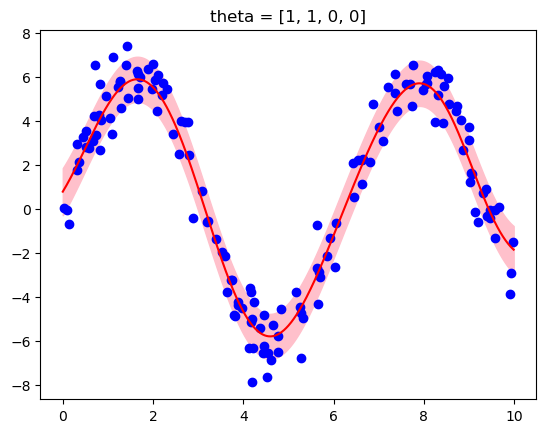

theta = [1, 1, 0, 0]
[RMS Error]
Training data:  0.9563642676105912
Testing data:  0.9600463323661679


In [120]:
c = CN(theta_sek, train_x)
pred(theta_sek,c)
RMSE(theta_sek, c)

#### theta = [1, 1, 0, 16]

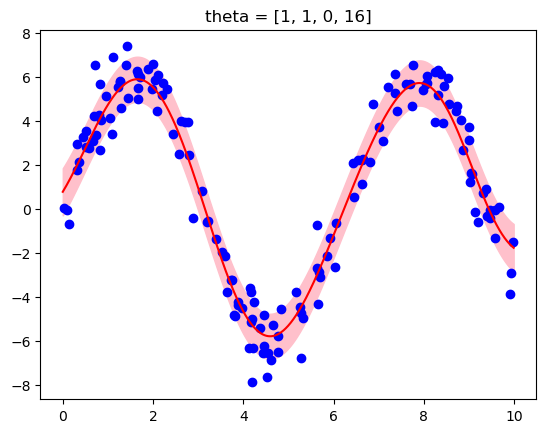

theta = [1, 1, 0, 16]
[RMS Error]
Training data:  0.9572824402560011
Testing data:  0.9624735743601458


In [121]:
c = CN(theta_eqk1, train_x)
pred(theta_eqk1,c)
RMSE(theta_eqk1, c)

#### theta = [1, 2, 16, 0]

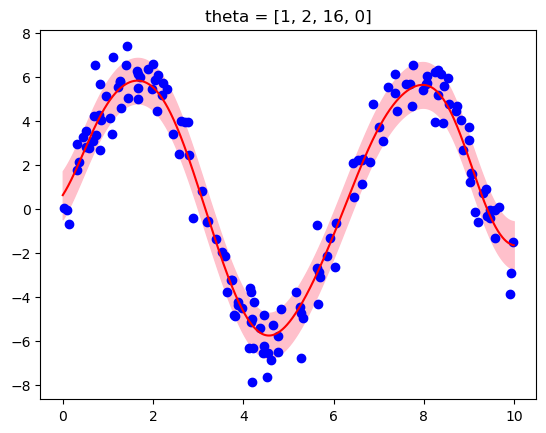

theta = [1, 2, 16, 0]
[RMS Error]
Training data:  0.9504982228584732
Testing data:  0.9707675411307138


In [122]:
c = CN(theta_eqk2, train_x)
pred(theta_eqk2,c)
RMSE(theta_eqk2, c)

-----

### 3 Tune the hyperparameter / Use automatic relevance determination (ARD)

In [123]:
beta_inv = 1
learning_rate = 0.1
iterations = 100
theta = [1, 2, 16, 0]
dev_func = [0, 0, 0, 0]
parameters = []

train_x = train_x.squeeze()
train_t = train_t.squeeze()
test_x = test_x.squeeze()
test_t = test_t.squeeze()

In [124]:
def exp_quad_kernel(x, y, theta):
    x = x.squeeze()
    y = y.squeeze()
    return theta[0]*np.exp(-0.5 * theta[1] * np.subtract.outer(x, y)**2) + theta[2] + theta[3] * np.multiply.outer(x, y)

In [125]:
def dev_log_like(C_inv, C_dev, t):
    return -0.5 * np.trace(C_inv.dot(C_dev)) + 0.5 * np.linalg.multi_dot([t.T, C_inv, C_dev, C_inv, t])

In [126]:
iterat = 0

while iterat < iterations:
    C_inv = np.linalg.inv(exp_quad_kernel(train_x, train_x, theta) + beta_inv * np.identity(150))
    # update parameter
    dev_func[0] = dev_log_like(C_inv, np.exp(-0.5 * theta[1] * np.subtract.outer(train_x, train_x)**2), train_t)
    dev_func[1] = dev_log_like(C_inv, theta[0] * -0.5 * np.subtract.outer(train_x, train_x) * np.exp(-0.5 * theta[1] *np.subtract.outer(train_x, train_x)**2), train_t)
    dev_func[2] = dev_log_like(C_inv, np.full([150, 150], 1), train_t)
    dev_func[3] = dev_log_like(C_inv, np.multiply.outer(train_x, train_x), train_t)
    
    parameters.append([p + learning_rate * dev for p, dev in zip(theta, dev_func)])
    new_p = [p + learning_rate * dev for p, dev in zip(theta, dev_func)]
    
#     print("Iteratrion: {}/{}".format(iterat, iterations))
#     print("theta = ", new_p)
#     print("")

    if np.max(np.abs(dev_func)) < 6:
        break
    
    iterat += 1

In [127]:
new_theta = parameters[-1]
print("fine tune theta = ", new_theta)

fine tune theta =  [6.1525854918420215, 2.0000000000000018, 15.99704900934143, -0.30912581276233375]


Finetune Hyperparameter (ARD)


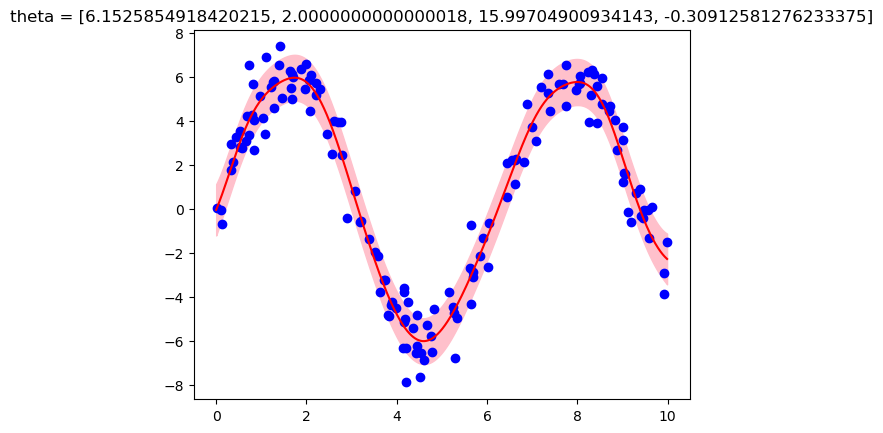

theta = [6.1525854918420215, 2.0000000000000018, 15.99704900934143, -0.30912581276233375]
[RMS Error]
Training data:  0.9146228745326511
Testing data:  0.9227026013628404


In [128]:
print("Finetune Hyperparameter (ARD)")
c = CN(new_theta, train_x)
pred(new_theta,c)
RMSE(new_theta, c)

#### 4 Explain your findings and do some discussion

根據以上實驗可以發現：

首先，使用Exponential-quadratic kernel function配合適當的hyperparameters，在本次實驗最終結果是優於使用Polynomail model。另外，當theta越複雜時，可以更擬合training data，且RMS error也會跟著變低。其中，第2組與第3組的表現差不多，多了一個theta4卻對結果沒造成太大的影響。最後，使用Automatic relevance determination (ARD)，可以對hyperparameter進行fine-tune，讓模型有更好的結果。
